In [2]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import data_path,results_path,grid_search,estimator_result,cross_validate,evaluate_param,rfecv
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV,VarianceThreshold

# Algorithm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train_X = load_npz(data_path + 'version_1/'+ 'train_bin.npz')
test_X = load_npz(data_path + 'version_1/'+ 'test_bin.npz')

train_y = pd.read_csv(data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv(data_path + 'test_Y.csv')['CMV_status']

**Select top 70 features(in terms of p-values)**

In [4]:
with open(data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)

p = 70
ind = TCRs_ind[:p]
train_X_sub = train_X[:,ind].toarray()
test_X_sub = test_X[:,ind].toarray()

## Define classifiers

In [5]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=31, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
                oob_score=True, random_state=0, verbose=0, warm_start=False)
lr = LogisticRegression(class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
                            penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
                            verbose=0, warm_start=False)
   
lr_l1 = LogisticRegression(class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
                            penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
                            verbose=0, warm_start=False)

## RFE for feature selection and Gridsearch for parameter tunning

### LR with L2

Optimal number of features : 62
Max cv score :  0.9519462037688637

Testing set:
AUROC: 0.9164535379369139 Accuracy:  0.9
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 36 38 39 40 41 43 45 46 47 48 49 50 51
 52 53 54 56 57 58 59 60 61 62 64 65 67 68]


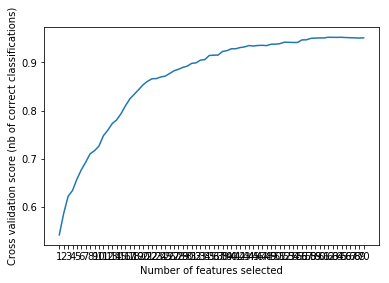

In [6]:
# p = 70
kept_ind = rfecv(train_X_sub,train_y,test_X_sub,test_y,lr)

#### Parameter tunning with optimal features

In [21]:
param_grid = {
    'C':[0.01,0.1,1,10,100]
}
grid_search(lr,train_X_sub[:,kept_ind],train_y,test_X_sub[:,kept_ind],test_y,param_grid)

Parameter_grid: {'C': [0.01, 0.1, 1, 10, 100]}
Best parameters set found on development set for AUC

{'C': 1}

Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Grid scores on training set:

AUROC: 0.945 (+/-0.042), Accuracy: 0.860 (+/-0.074) for {'C': 0.01}
AUROC: 0.951 (+/-0.037), Accuracy: 0.886 (+/-0.063) for {'C': 0.1}
AUROC: 0.954 (+/-0.039), Accuracy: 0.900 (+/-0.074) for {'C': 1}
AUROC: 0.947 (+/-0.049), Accuracy: 0.891 (+/-0.076) for {'C': 10}
AUROC: 0.939 (+/-0.058), Accuracy: 0.895 (+/-0.083) for {'C': 100}

Best AUROC: 0.953831161456639  with Accuracy: 0.9001560062402496

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full testing set.

             precision    recall  f1-score   sup

In [39]:
with open(data_path + 'feature_selection/'+'bin/'+'best_lr_62', 'wb') as f:
    pickle.dump(kept_ind, f, pickle.HIGHEST_PROTOCOL)

### LR with L1

Optimal number of features : 68
Max cv score :  0.944126593166002

Testing set:
AUROC: 0.9124751349815288 Accuracy:  0.875


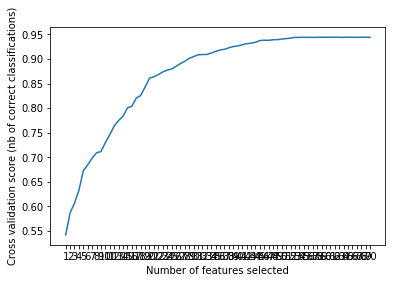

In [7]:
# p = 70
kept_ind2 = rfecv(train_X_sub,train_y,test_X_sub,test_y,lr_l1)

**The 29,69 features are dropped**

In [42]:
param_grid = {
    'C':[0.01,0.1,1,2,3,10,100]
}
grid_search(lr_l1,train_X_sub[:,:70],train_y,test_X_sub[:,:70],test_y,param_grid)

Parameter_grid: {'C': [0.01, 0.1, 1, 2, 3, 10, 100]}
Best parameters set found on development set for AUC

{'C': 1}

Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Grid scores on training set:

AUROC: 0.500 (+/-0.000), Accuracy: 0.549 (+/-0.007) for {'C': 0.01}
AUROC: 0.813 (+/-0.101), Accuracy: 0.729 (+/-0.098) for {'C': 0.1}
AUROC: 0.944 (+/-0.044), Accuracy: 0.889 (+/-0.069) for {'C': 1}
AUROC: 0.944 (+/-0.041), Accuracy: 0.891 (+/-0.073) for {'C': 2}
AUROC: 0.941 (+/-0.044), Accuracy: 0.891 (+/-0.073) for {'C': 3}
AUROC: 0.939 (+/-0.052), Accuracy: 0.894 (+/-0.068) for {'C': 10}
AUROC: 0.931 (+/-0.056), Accuracy: 0.886 (+/-0.085) for {'C': 100}

Best AUROC: 0.9440445663803564  with Accuracy: 0.8892355694227769

Detailed classification report:

The model i

### RF

Optimal number of features : 68
Max cv score :  0.9451786691688169

Testing set:
AUROC: 0.9381926683716965 Accuracy:  0.9166666666666666
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 55 56 57 59 60 61 62 63 64 65 66 67 68 69]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

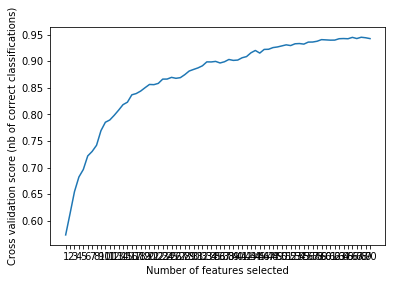

In [7]:
# p = 70
rfecv(train_X_sub,train_y,test_X_sub,test_y,rf)